# Исследование тарифных планов оператора сотовой связи

**Цель проекта**: 
анализ поведения 500 пользователей оператора сотовой связи за 2018 год для выбора наиболее выгодного для компании тарифа. 

**Исходные данные**: 
Информация о пользователях:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Информация о звонках:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Информация о сообщениях:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Информация об интернет-сессиях:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Информация о тарифах:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета

**Основные этапы проекта**:
- Изучение предоставленных данных
- Очистка и предобработка данных
- Предварительные расчёты:
    - количества сделанных звонков и израсходованных минут разговора по месяцам
    - количества отправленных сообщений по месяцам
    - объема израсходованного интернет-трафика по месяцам
    - помесячной выручки от каждого пользователя
- Анализ данных:
    - анализ основных статистических метрик в разрезе тарифов
    - построение и анализ графиков распределения в разрезе тарифов
    - проверка гипотез
- Общий вывод и рекомендации


## Изучение данных из файла

Рассмотрим каждый из предоставленных файлов в отдельности.

**Информация о звонках:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
from functools import reduce

calls = pd.read_csv('/calls.csv')
print(calls.info())
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В таблице содержатся данные о 202 607 звонках, пропусков в данных нет.

**Информация об интернет-сессиях:**

In [2]:
internet = pd.read_csv('/internet.csv', index_col=0)
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


У нас есть данные о 149 396 интернет-сессиях, пропусков в данных нет.

**Информация о сообщениях:**

In [3]:
messages = pd.read_csv('/messages.csv')
print(messages.info())
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


В таблице содержатся данные о 123 036 сообщениях, пропусков в данных нет.

**Информация о тарифах:**

In [4]:
tariffs = pd.read_csv('/tariffs.csv')
print(tariffs.info())
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Эта таблица представляет собой справочник с условиями двух тарифов, которые предстоит сравнивать.

**Информация о пользователях:**

In [5]:
users = pd.read_csv('/users.csv')
print(users.info())
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Эта таблица представляет собой справочник с данными по каждому клиенту. Пропуски в столбце 'churn_date' означают, что указанный тариф действовал на момент выгрузки. Избавляться от них не будем.

### Вывод

У нас в распоряжении 5 таблиц с данными о звонках, сообщениях и интернет-сессиях клиентов, две таблицы представляют собой справочники с данными об условиях тарифов и данными клиентов. 


Пропусков, от которых необходимо избавиться, не обнаружено. 
В таблице с данными об интернет сессиях мы избавились от первого столбца, дублирующего индексы таблицы. 
В каждой таблице, содержащей столбец с датами, тип данных необходимо будет привести к типу datetime.  

## Предобработка данных

В каждой таблице рассмотрим подробнее столбцы и переведём данные о дате в формат datetime, а данные с идентификатором пользователя - в тип object (поскольку математические операции с этим столбцом нам не нужны). Поскольку для дальнейшего анализа нам понадобится только месяц, выделим его в отдельный столбец. 

**Информация о пользователях:**

In [6]:
users['user_id'].value_counts()

1023    1
1194    1
1181    1
1182    1
1183    1
       ..
1362    1
1363    1
1364    1
1365    1
1024    1
Name: user_id, Length: 500, dtype: int64

Мы убедились, что у нас в справочнике действительно информация о 500 уникальных пользователях. Переведём столбец с ID в текстовый формат, а информацию с датой регистрации - в формат datetime:

In [7]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['user_id'] = users['user_id'].astype(str)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null object
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 31.4+ KB


**Информация о звонках:**

In [8]:
calls['user_id'].value_counts()

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

У нас в таблице данные о 492 пользователях из 500. Видимо, не все пользователи совершали звонки в 2018 году. Причины могут быть разные: они уже не пользуются сим-картой нашего оператора, или же они зарегистрированы в самом конце года и не успели совершить ни одного звонка, или сим-карта используется в планшете, с которого звонки в принципе невозможны. Можно также отметить, что есть очень активные и неактивные пользователи: количество зафиксированных звонков колеблется от 14 до 1760.

Проверим таблицу на явные дубликаты:

In [9]:
calls.duplicated().sum()

0

С дубликатами проблем нет. 

Теперь изменим тип столбцов с датой и ID клиента:

In [10]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['user_id'] = calls['user_id'].astype(str)
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Рассмотрим подробнее столбец со временем звонка:

In [11]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Среднее и медианное время звонка похожи: 6,75 и 6 минут соответственно. Минимальное время - 0 (не дозвонились), максимальное - 38 минут. 

Выделим строки с нулевым временем звонка:

In [12]:
calls.query('duration == 0')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


Поскольку нас интересуют только те звонки, которые тарифицировались оператором, то есть приносили ему прибыль, удалим из рассмотрения все звонки с нулевой продолжительностью. Таких звонков 39 613 или 19,5%: 

In [13]:
calls = calls.query('duration > 0')
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.2+ MB


**Информация об интернет-сессиях:**

In [14]:
internet['user_id'].value_counts()

1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64

3 пользователя из 500 не выходили в Интернет с использованием своей сим-карты.

In [15]:
internet.duplicated().sum()

0

С дубликатами проблем нет. 

Рассмотрим подробно столбец с данными о потреблённом трафике:

In [16]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Среднее количество потреблённых за сессию Мб: 370, максимальное - 1724, минимальное - 0. Поскольку сессии с нулевым траффиком не будут участвовать в анализе, их можно удалить:

In [17]:
internet.query('mb_used == 0')

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


In [18]:
internet = internet.query('mb_used > 0')

Изменим тип столбцов с датой и ID клиента:

In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['user_id'] = internet['user_id'].astype(str)
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.0+ MB


**Информация о сообщениях:**

Проверим на дубликаты:

In [20]:
messages.duplicated().sum()

0

Изменим тип столбцов с датой и ID клиента:

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['user_id'] = messages['user_id'].astype(str)
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.0+ MB


In [22]:
messages['user_id'].value_counts()

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

Если звонками и мобильным Интернетом пользуется подавляющее большинство клиентов, то сообщений не писали уже гораздо больше людей: 74 человека из 500. 

### Вывод

Каких-то серьёзных проблем в предоставленных данных не было. В рамках предобработки:
- убедились в отсутствии явных дубликатов в каждой таблице;
- тип столбцов с датой изменили на datetime, тип столбцов с ID клиента - на строковый;
- удалили нулевые значения в данных о звонках и интернет-сессиях, поскольку такие звонки и сессии в дальнейшем анализе не участвуют.

Попутно обнаружили, что не все пользователи из рассмотренных 500 совершали звонки, пользовались мобильным Интернетом и писали сообщения. 

## Расчёты и добавление результатов в таблицу

Выделим месяц совершения звонка в отдельный столбец для каждой таблицы:

In [23]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month              # звонки
internet['month'] = pd.DatetimeIndex(internet['session_date']).month     # интернет-сессии
messages['month'] = pd.DatetimeIndex(messages['message_date']).month     # сообщения

display(internet.head())
display(messages.head())

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Наш оператор всегда округляет секунды до минут. Поэтому для анализа нам понадобится стобец с длительностью звонка, округлённом в большую сторону до целого:

In [24]:
calls['duration_minutes'] = np.ceil(calls['duration']).astype(int)
calls.head()

,id,call_date,duration,user_id,month,duration_minutes
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6
7,1000_7,2018-08-22,18.31,1000,8,19
8,1000_8,2018-09-15,18.44,1000,9,19


Теперь посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя. Будем использовать округлённые до целых минут значения:

In [25]:
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = 'duration_minutes', aggfunc = ['count', 'sum'])
calls_pivot.columns = ['duration_count', 'duration_sum']
calls_pivot.head(10)                                                                      

duration_count  duration_sum
user_id month                              
1000    5                  17           159
        6                  28           172
        7                  41           340
        8                  42           408
        9                  46           466
        10                 44           350
        11                 37           338
        12                 38           333
1001    11                 45           430
        12                 47           414

Посчитаем количество отправленных сообщений по месяцам для каждого пользователя:

In [26]:
messages_pivot = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
messages_pivot.columns = ['messages_count']
messages_pivot.head(10)  

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
        10                 73
        11                 58
        12                 70
1002    6                   4
        7                  11

Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя:

In [27]:
internet_pivot = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot.columns = ['mb_used_sum']
internet_pivot.head(10)  

mb_used_sum
user_id month             
1000    5          2253.49
        6         23233.77
        7         14003.64
        8         14055.93
        9         14568.91
        10        14702.49
        11        14756.47
        12         9817.61
1001    11        18429.34
        12        14036.66

По правилам оператора, для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Добавим в сводную таблицу столбец с округлённым количеством Гб:

In [28]:
internet_pivot['gb_used'] = np.ceil(internet_pivot['mb_used_sum'] / 1024).astype(int)
internet_pivot.head(10)

mb_used_sum  gb_used
user_id month                      
1000    5          2253.49        3
        6         23233.77       23
        7         14003.64       14
        8         14055.93       14
        9         14568.91       15
        10        14702.49       15
        11        14756.47       15
        12         9817.61       10
1001    11        18429.34       18
        12        14036.66       14

Объединим данные для анализа в одну таблицу:

In [29]:
pivot_data = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), [internet_pivot, calls_pivot,  messages_pivot]).reset_index()
pivot_data  

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count
0,1000,5,2253.49,3.0,17.0,159.0,22.0
1,1000,6,23233.77,23.0,28.0,172.0,60.0
2,1000,7,14003.64,14.0,41.0,340.0,75.0
3,1000,8,14055.93,14.0,42.0,408.0,81.0
4,1000,9,14568.91,15.0,46.0,466.0,57.0
...,...,...,...,...,...,...,...
3209,1273,12,NaN,NaN,38.0,260.0,39.0
3210,1365,10,NaN,NaN,5.0,43.0,1.0
3211,1377,2,NaN,NaN,20.0,179.0,2.0
3212,1392,2,NaN,NaN,2.0,13.0,3.0


В нашей таблице теперь присутствуют пропущеные значения, поскольку, как мы уже отмечали, не каждый пользователь общался всеми тремя способами коммуникации, кроме того, не каждый месяц используется тот или иной вид трафика. Заменим пропуски в столбцах с данными на 0.   

In [30]:
pivot_data.loc[pivot_data['messages_count'].isna()].head() # на примере столбца с количеством сообщений

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count
8,1001,11,18429.34,18.0,45.0,430.0,NaN
9,1001,12,14036.66,14.0,47.0,414.0,NaN
42,1006,2,1392.15,2.0,3.0,42.0,NaN
43,1006,3,17287.93,17.0,36.0,286.0,NaN
44,1006,4,13936.70,14.0,38.0,356.0,NaN


In [31]:
pivot_data['duration_count'] = pivot_data['duration_count'].fillna(0)
pivot_data['duration_sum'] = pivot_data['duration_sum'].fillna(0)
pivot_data['messages_count'] = pivot_data['messages_count'].fillna(0)
pivot_data['mb_used_sum'] = pivot_data['mb_used_sum'].fillna(0)
pivot_data['gb_used'] = pivot_data['gb_used'].fillna(0)
pivot_data.loc[pivot_data['messages_count'].isna()]                       # проверяем на примере столбца с количеством сообщений

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count


Добавим информацию об используемом тарифе:

In [32]:
tarif = users.loc[:, ['user_id', 'tariff']]  # выделили в отдельный фрейм данные об ID и тарифе 
tarif.columns = ['user_id', 'tariff_name']
tarif

,user_id,tariff_name
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra
...,...,...
495,1495,ultra
496,1496,smart
497,1497,smart
498,1498,smart


In [33]:
pivot_with_tarif = pivot_data.merge(tarif, on = 'user_id', how = 'left')
pivot_with_tarif

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra
...,...,...,...,...,...,...,...,...
3209,1273,12,0.00,0.0,38.0,260.0,39.0,ultra
3210,1365,10,0.00,0.0,5.0,43.0,1.0,smart
3211,1377,2,0.00,0.0,20.0,179.0,2.0,ultra
3212,1392,2,0.00,0.0,2.0,13.0,3.0,ultra


Добавим данные об условиях из справочника о тарифных планах:

In [34]:
pivot_cond = pivot_with_tarif.merge(tariffs, on = 'tariff_name', how = 'left')
pivot_cond

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1273,12,0.00,0.0,38.0,260.0,39.0,ultra,1000,30720,3000,1950,150,1,1
3210,1365,10,0.00,0.0,5.0,43.0,1.0,smart,50,15360,500,550,200,3,3
3211,1377,2,0.00,0.0,20.0,179.0,2.0,ultra,1000,30720,3000,1950,150,1,1
3212,1392,2,0.00,0.0,2.0,13.0,3.0,ultra,1000,30720,3000,1950,150,1,1


Теперь рассчитаем помесячную выручку с каждого пользователя по следующему правилу: из суммарного количества звонков, сообщений и интернет-трафика вычитается бесплатный лимит, остаток умножается на стоимость единицы из тарифного плана, прибавляется абонентская плата соответствующего тарифного плана.

In [35]:
# функция для подсчёта доходов
def income(row):                   
    total_income = 0
    calls_income = 0
    messages_income = 0
    internet_income = 0
    if row['duration_sum'] > row['minutes_included']:
        calls_income = (row['duration_sum'] - row['minutes_included']) * row['rub_per_minute']
    if row['messages_count'] > row['messages_included']:
        messages_income = (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    if row['gb_used'] > (row['mb_per_month_included'] / 1024):
        internet_income = (row['gb_used'] - row['mb_per_month_included'] / 1024) * row['rub_per_gb']
    total_income = calls_income + messages_income + internet_income + row['rub_monthly_fee']
    return total_income

# расчёты добавим в новый столбец
pivot_cond['income'] = pivot_cond.apply(income, axis = 1)                     
pivot_cond.head()

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra,1000,30720,3000,1950,150,1,1,1950.0


Проверим расчёт для пары примеров, когда клиент вышел за рамки бесплатных пакетов:

In [36]:
pivot_cond.query('duration_sum > minutes_included').head(2)

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
32,1005,3,11104.25,11.0,63.0,606.0,56.0,smart,50,15360,500,550,200,3,3,886.0
33,1005,4,9351.72,10.0,77.0,712.0,41.0,smart,50,15360,500,550,200,3,3,1186.0


Функция работает корректно.

Для наглядности оставим в сводной таблице только данные, которые в дальнейшем будут использованы для анализа:

In [37]:
pivot_incomes = pivot_cond.loc[:, ['user_id', 'month', 'mb_used_sum', 'gb_used', 'duration_count', 'duration_sum', 'messages_count', 'tariff_name', 'income']]
pivot_incomes.head()

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra,1950.0
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra,1950.0
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra,1950.0
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra,1950.0
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra,1950.0


### Вывод

Для каждого пользователя были рассчитаны следующие показатели:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячная выручка.

## Исследовательский анализ данных

Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц на примере имеющейся выборки:

In [38]:
ultra = pivot_incomes.query('tariff_name == "ultra"') # для тарифа "Ультра"
display(ultra.head())

smart = pivot_incomes.query('tariff_name == "smart"') # для тарифа "Смарт"
display(smart.head())

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra,1950.0
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra,1950.0
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra,1950.0
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra,1950.0
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra,1950.0


,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income
8,1001,11,18429.34,18.0,45.0,430.0,0.0,smart,1150.0
9,1001,12,14036.66,14.0,47.0,414.0,0.0,smart,550.0
10,1002,6,10856.82,11.0,14.0,117.0,4.0,smart,550.0
11,1002,7,17580.10,18.0,21.0,214.0,11.0,smart,1150.0
12,1002,8,20319.26,20.0,37.0,289.0,13.0,smart,1550.0


In [39]:
print('Количество клиентов, выбравших тариф "Ультра":', len(ultra['user_id'].unique()))
print('Сумма выручки, которую принесли клиенты тарифа "Ультра" за 2018 год:', ultra['income'].sum())
stat_ultra = ultra.describe().T

# расчёт выборочной дисперсии
stat_ultra['var'] = (stat_ultra['std']**2).round(1)
stat_ultra

Количество клиентов, выбравших тариф "Ультра": 148
Сумма выручки, которую принесли клиенты тарифа "Ультра" за 2018 год: 2039100.0


,count,mean,std,min,25%,50%,75%,max,var
month,985.0,8.250761,2.871762,1.0,6.00,9.00,11.00,12.00,8.2
mb_used_sum,985.0,19468.805208,10087.170752,0.0,11770.26,19308.01,26837.69,49745.69,101751013.8
gb_used,985.0,19.494416,9.853511,0.0,12.00,19.00,27.00,49.00,97.1
duration_count,985.0,59.236548,35.562722,0.0,33.00,58.00,84.00,190.00,1264.7
duration_sum,985.0,526.623350,317.606098,0.0,284.00,518.00,752.00,1673.00,100873.6
messages_count,985.0,49.363452,47.804457,0.0,6.00,38.00,79.00,224.00,2285.3
income,985.0,2070.152284,376.187114,1950.0,1950.00,1950.00,1950.00,4800.00,141516.7


Тарифом "Ультра" пользуется 148 клиентов из нашей выборки. Сумма выручки от этого тарифа за год составила 2 млн. руб.

В среднем, пользователям этого тарифа требуется 527 минут звонков, 49 сообщений, 19 Гб интернет-трафика. Средний доход, который приносит клиент этого тарифа - 2070 руб. Однако, если основываться на медианном значении, средний клиент платит только абонентскую плату - 1950 руб/месяц, а превышение получается за счёт небольшого количества клиентов, которые используют намного больше траффика.

In [40]:
print('Количество клиентов, выбравших тариф "Смарт":', len(smart['user_id'].unique()))
print('Сумма выручки, которую принесли клиенты тарифа "Смарт" за 2018 год:', smart['income'].sum())
stat_smart = smart.describe().T

# расчёт выборочной дисперсии
stat_smart['var'] = (stat_smart['std']**2).round(1)
stat_smart

Количество клиентов, выбравших тариф "Смарт": 350
Сумма выручки, которую принесли клиенты тарифа "Смарт" за 2018 год: 2875351.0


,count,mean,std,min,25%,50%,75%,max,var
month,2229.0,8.346792,2.920316,1.0,6.00,9.00,11.00,12.00,8.5
mb_used_sum,2229.0,16208.386990,5870.476681,0.0,12643.01,16506.84,20042.93,38552.45,34462496.5
gb_used,2229.0,16.328847,5.747061,0.0,13.00,17.00,20.00,38.00,33.0
duration_count,2229.0,46.947510,21.039171,0.0,32.00,47.00,61.00,162.00,442.6
duration_sum,2229.0,417.934948,190.313730,0.0,282.00,422.00,545.00,1435.00,36219.3
messages_count,2229.0,33.384029,28.227876,0.0,10.00,28.00,51.00,143.00,796.8
income,2229.0,1289.973531,818.404367,550.0,550.00,1023.00,1750.00,6770.00,669785.7


Тариф "Смарт" выбирают чаще: 350 клиентов из выборки. Сумма выручки от этого тарифа за год составила 2,9 млн. руб. 

Пользователям этого тарифа требуется в среднем 418 минут разговора, 33 сообщения и 16 Гб интернет-трафика - меньше, чем пользователям тарифа "Ультра". Средний доход, который приносит клиент в рамках тарифа "Смарт" - 1290 руб., медианный - 1023 руб, нижний квартиль  - 550 руб., равен абонентской плате. То есть более 50% пользователей этого тарифа не укладывается в бесплатный пакет в рамках абонентской платы, им приходится платить за услуги сверх лимита.

Отобразим графически распределения интересующих нас показателей тарифов.

Начнём с **распределения времени разговора в месяц**:

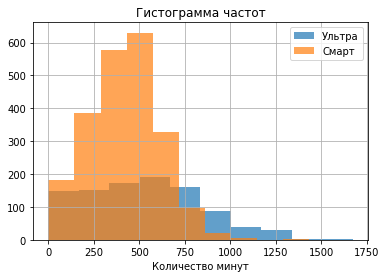

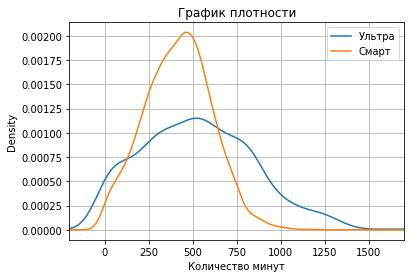

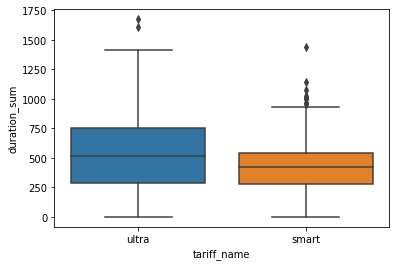

In [41]:
# частотная гистограмма
ultra['duration_sum'].hist(alpha = 0.7)
smart['duration_sum'].hist(alpha = 0.7)
plt.title('Гистограмма частот')
plt.xlabel('Количество минут')
plt.legend(['Ультра', 'Смарт'])
plt.show()

# график плотности
ultra['duration_sum'].plot(kind='density')
smart['duration_sum'].plot(kind='density')
plt.title('График плотности')
plt.xlabel('Количество минут')
plt.legend(['Ультра', 'Смарт'])
plt.xlim(-200, 1700)
plt.grid(True)
plt.show()

# боксплот
sns.boxplot(x = pivot_incomes['tariff_name'], y = pivot_incomes['duration_sum'])
plt.show()

Оба распределения близки к нормальным, ассимметричны, скошены вправо, со средним около 500 минут (точнее - 418 для тарифа "Смарт" и 527 для тарифа "Ультра"). Распределение минут в тарифе "Смарт" - более компактное, распределение для тарифа "Ультра" имеет значительно большее стандартное отклонение (190 и 318 соответственно), что говорит о большем количестве абонентов дорогого тарифа "Ультра", которые тратят времени на разговоры больше среднего (а значит, не зря выбрали для себя данный тариф). 1,5 межквартильного размаха от верхнего квартиля для тарифа "Ультра" заканчивается на значениях около 1400 минут, тогда как для тарифа "Смарт" - в районе 900 минут. При этом абонентов, разговаривающих аномально много по сравнению с большинством, в тарифе "Ультра" всего 2, тогда как в тарифе "Смарт" - лостаточно много. И тем не менее, максимум разговоров в месяц принадлежит абоненту тарифа "Ультра" - 1674 минуты против 1435 минут в месяц для абонентов "Смарт".  

**Распределение количества сообщений в месяц**:

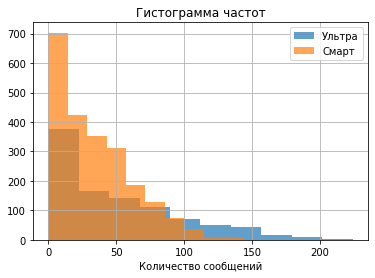

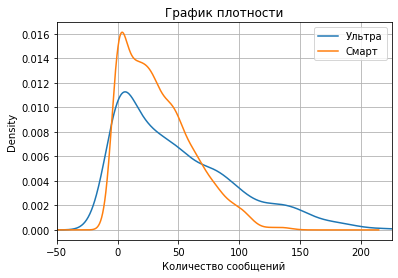

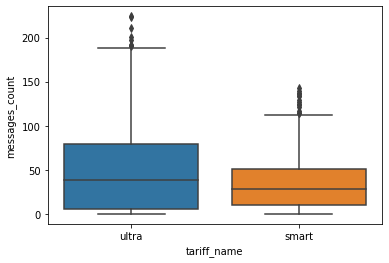

In [42]:
# частотная гистограмма
ultra['messages_count'].hist(alpha = 0.7)
smart['messages_count'].hist(alpha = 0.7)
plt.title('Гистограмма частот')
plt.xlabel('Количество сообщений')
plt.legend(['Ультра', 'Смарт'])
plt.show()

# график плотности
ultra['messages_count'].plot(kind='density')
smart['messages_count'].plot(kind='density')
plt.title('График плотности')
plt.xlabel('Количество сообщений')
plt.legend(['Ультра', 'Смарт'])
plt.xlim(-50, 225)
plt.grid(True)
plt.show()

# боксплот
sns.boxplot(x = pivot_incomes['tariff_name'], y = pivot_incomes['messages_count'])
plt.show()

Оба распределения количества сообщений в месяц близки к нормальным, ассимметричны, сильно скошены вправо, со средним около 40 ( 33 для тарифа "Смарт" и 49 для тарифа "Ультра"). Распределение в тарифе "Смарт" снова выглядит более компактным, распределение для тарифа "Ультра" имеет большее стандартное отклонение (28 и 48 соответственно). 75% пользователей тарифа "Смарт" укладываются в  51 сообщение в месяц, тогда как 75% абонентов тарифа "Ультра" - в 79 сообщений в месяц. В обеих выборках достаточно много абонентов, использующих гораздо больше вообщений, нежели средний абонент. Максимум сообщений в месяц в тарифе "Смарт" - 143, в тарифе "Ультра" - 224.

**Распределение использования интернет-трафика в месяц**:

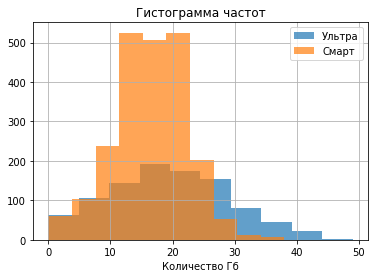

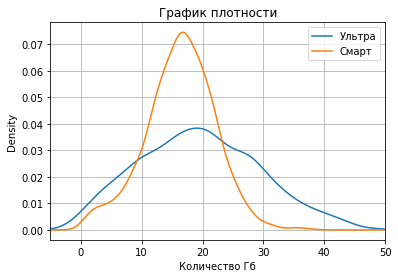

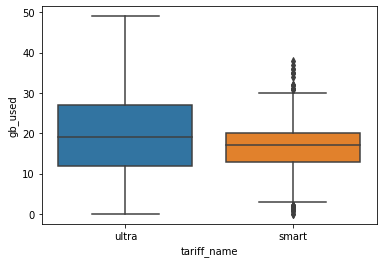

In [43]:
# частотная гистограмма
ultra['gb_used'].hist(alpha = 0.7)
smart['gb_used'].hist(alpha = 0.7)
plt.title('Гистограмма частот')
plt.xlabel('Количество Гб')
plt.legend(['Ультра', 'Смарт'])
plt.show()

# график плотности
ultra['gb_used'].plot(kind = 'density')
smart['gb_used'].plot(kind= 'density')
plt.title('График плотности')
plt.xlabel('Количество Гб')
plt.legend(['Ультра', 'Смарт'])
plt.xlim(-5, 50)
plt.grid(True)
plt.show()

# боксплот
sns.boxplot(x = pivot_incomes['tariff_name'], y = pivot_incomes['gb_used'])
plt.show()

Оба распределения близки к нормальным, практически симметричны, со средним для тарифа "Смарт" - 16Гб, для тарифа "Ультра" - 19Гб. Распределение в тарифе "Смарт", как и впредыдущих случаях - более узкое, распределение для тарифа "Ультра" - более широкое, стандартные отклонения равны 6 и 10 Гб соответственно. При этом в выборке абонентов тариа "Ультра" вообще нет выбросов, все абоненты укладываются в рамки, описанные распределением (за счёт того, что оно более вариативно и предполагает более широкие рамки), и используют в месяц не более 49Гб в месяц. Тогда как в распределении для абонентов тарифа "Смарт" много выбросов как сверху, так и снизу при максимуме в 38 Гб с месяц, то есть поведение абонентов этого тарифа более унифицированное, подавляющее большинство абонентов использует в месяц примерно 3 - 30 Гб трафика.  

**Распределение месячных доходов от абонентов**:

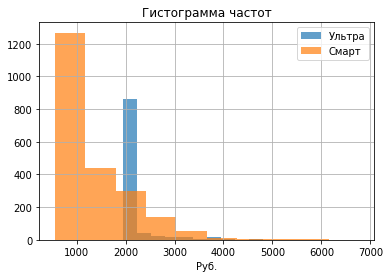

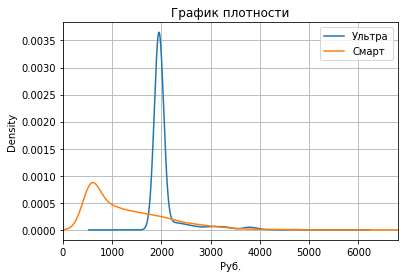

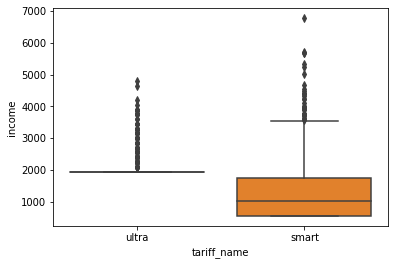

In [44]:
# частотная гистограмма
ultra['income'].hist(alpha = 0.7)
smart['income'].hist(alpha = 0.7)
plt.title('Гистограмма частот')
plt.xlabel('Руб.')
plt.legend(['Ультра', 'Смарт'])
plt.show()

# график плотности
ultra['income'].plot(kind='density')
smart['income'].plot(kind='density')
plt.title('График плотности')
plt.xlabel('Руб.')
plt.legend(['Ультра', 'Смарт'])
plt.xlim(0, 6800)
plt.grid(True)
plt.show()

# боксплот
sns.boxplot(x = pivot_incomes['tariff_name'], y = pivot_incomes['income'])
plt.show()

Оба распределения близки к нормальным,с выраженной ассимметрией вправо, со медианами для тарифа "Смарт" - 1023 руб., для тарифа "Ультра" - 1950 руб. На этот раз распределение доходов от тарифа "Ультра" гораздо уже, чем у тарифа "Смарт", что обусловлено условиями тарифных планов, - более 75% абонентов тарифа "Ультра" платят абонентскую плату 1950 руб./мес. и укладываются в рамки предоставленных пакетов. Тогда как в рамках тарифа "Смарт" менее 50% абонентов удаётся уложиться в рамки пакетов, для этого тарифа уже медианное значение затрат на связь превышет абонентскую плату 550 руб./месяц. Выбросов достаточно много в каждом распределении, оба сильно скошены вправо, что говорит о наличии большого количества абонентов, тратящих на связь гораздо больше средних сумм. Удивительно, но максимум затрат на связь в месяц приходится не на абонентов дорогого тарифа "Ультра", а на клиентов более дешёвого "Смарт" - 6770 руб. (максимум для тарифа "Ультра" - 4800 руб.). Взглянем на них:  

In [45]:
smart.query('income > 5000')

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income
260,1042,12,37165.69,37.0,94.0,728.0,75.0,smart,5709.0
622,1098,12,36523.90,36.0,63.0,588.0,14.0,smart,5014.0
1016,1159,12,35135.89,35.0,85.0,734.0,2.0,smart,5252.0
1646,1261,12,32650.91,32.0,113.0,1074.0,22.0,smart,5672.0
1809,1286,12,35108.07,35.0,83.0,739.0,68.0,smart,5321.0
3127,1486,11,36266.11,36.0,84.0,764.0,96.0,smart,5680.0
3128,1486,12,38552.45,38.0,115.0,1007.0,83.0,smart,6770.0


Веротяно, этим абонентам стоит пересмотреть свой тариф, поскольку в тарифе "Ультра" расценки на трафик сверх лимита ниже, чем в тарифе "Смарт". Примечательно, что почти все сверхрасходы приходятся на декабрь.

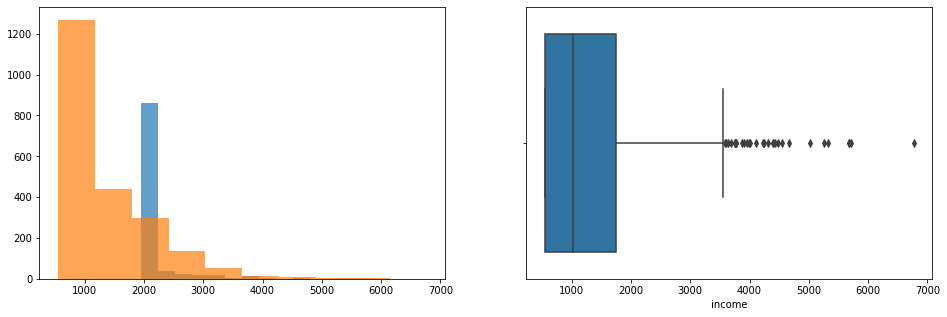

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].hist(ultra['income'],alpha = 0.7)
axs[0].hist(smart['income'],alpha = 0.7)
axs[1] = sns.boxplot(smart['income'])
plt.show()

**Проверим следующие гипотезы:**
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Уровень статистической значимости примем равным 5%.

---
**1.** Гипотеза H0: средняя выручка пользователей тарифов «Ультра» равна средней выручке тарифа «Смарт».
   Гипотеза H1: средняя выручка пользователей тарифов «Ультра» не равна средней выручке тарифа «Смарт»

In [47]:
# проверка равенства дисперсий:
print('Выборочная дисперсия для тарифа "Ультра":', np.var(ultra['income'], ddof = 1))
print('Выборочная дисперсия для тарифа "Смарт":', np.var(smart['income'], ddof = 1), '\n')

alpha = 0.05
results = st.ttest_ind(smart['income'], ultra['income'], equal_var = False) # дисперсии выборок сильно отличаются, отразили это в расчёте
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем H0')
else:
    print('Не получилось отвергнуть H0')

Выборочная дисперсия для тарифа "Ультра": 141516.74507861826
Выборочная дисперсия для тарифа "Смарт": 669785.7080064242 

p-значение: 4.2606313931076085e-250
Отвергаем H0


Значение p-value значительно ниже уровня статистической значимости в 5%, а значит, нулевую гипотезу стоит отвергнуть: с большой вероятностью средние значения выручки от клиентов тарифов "Ультра" и "Смарт" не равны (и как мы уже разобрали выше, это соответствует данным нашей выборки).

---
**2.** Гипотеза Н0: средняя выручка от клиентов из Москвы равна выручке от клиентов из других регионов. Гипотеза Н1: средняя выручка от клиентов из Москвы отличается от выручки от клиентов из других регионов.

Для проверки этой гипотезы сперва добавим в сводную таблицу данные о городах абонентов.

In [48]:
cities = users.loc[:, ['user_id', 'city']] # создали справочник с городами для объединения
cities.head()

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк


In [49]:
pivot_with_city = pivot_incomes.merge(cities, on = 'user_id', how = 'left') # добавляем данные по городам к сводной таблице
pivot_with_city.head()

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income,city
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra,1950.0,Краснодар
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra,1950.0,Краснодар
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra,1950.0,Краснодар
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra,1950.0,Краснодар
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra,1950.0,Краснодар


In [50]:
Msk_incomes = pivot_with_city.query('city == "Москва"')                              # фильтр по Москве
non_Msk_incomes = pivot_with_city.query('city != "Москва"')                          # остальные регионы
display(Msk_incomes.head())

# посчитаем среднее по нашей выборке для москвичей и других регионов
print('Средний доход от москвича:', Msk_incomes['income'].mean())             
display(non_Msk_incomes.head())
print('Средний доход от жителя другого региона:', non_Msk_incomes['income'].mean()) 

,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income,city
8,1001,11,18429.34,18.0,45.0,430.0,0.0,smart,1150.0,Москва
9,1001,12,14036.66,14.0,47.0,414.0,0.0,smart,550.0,Москва
17,1003,8,8565.21,9.0,43.0,380.0,37.0,ultra,1950.0,Москва
18,1003,9,12468.87,13.0,105.0,961.0,91.0,ultra,1950.0,Москва
19,1003,10,14768.14,15.0,97.0,855.0,83.0,ultra,1950.0,Москва


Средний доход от москвича: 1546.7135842880523


,user_id,month,mb_used_sum,gb_used,duration_count,duration_sum,messages_count,tariff_name,income,city
0,1000,5,2253.49,3.0,17.0,159.0,22.0,ultra,1950.0,Краснодар
1,1000,6,23233.77,23.0,28.0,172.0,60.0,ultra,1950.0,Краснодар
2,1000,7,14003.64,14.0,41.0,340.0,75.0,ultra,1950.0,Краснодар
3,1000,8,14055.93,14.0,42.0,408.0,81.0,ultra,1950.0,Краснодар
4,1000,9,14568.91,15.0,46.0,466.0,57.0,ultra,1950.0,Краснодар


Средний доход от жителя другого региона: 1524.9362274298885


In [51]:
# проверка равенства дисперсий
print('Выборочная дисперсия для доходов от москвичей:', np.var(Msk_incomes['income'], ddof = 1))
print('Выборочная дисперсия для доходов от других регионов:', np.var(non_Msk_incomes['income'], ddof = 1), '\n')

# дисперсии приблизительно одного порядка, поэтому в расчёте поправку не делаем 
alpha = 0.05
results = st.ttest_ind(Msk_incomes['income'], non_Msk_incomes['income'])
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем H0')
else:
    print('Не получилось отвергнуть H0')

Выборочная дисперсия для доходов от москвичей: 565636.467011886
Выборочная дисперсия для доходов от других регионов: 654137.6285218114 

p-значение: 0.5440152911670224
Не получилось отвергнуть H0


Значение p-value равно 5,4%, а значит, нулевую гипотезу отвергать не стоит: с большой вероятностью средние значения выручки от жителей Москвы и других регионов приблизительно равны (и мы уже убедились, что для нашей выборки это так).

## Вывод

Мы проанализировали поведение клиентов двух тарифов оператора сотовой связи и выяснили, что в среднем клиенты более дорогого тарифа «Ультра» говорят по мобильному телефону больше, больше пишут сообщений и больше пользуются Интернетом, чем абонеты более дешёвого тарифа «Смарт». При этом распределения этих показателей в тарифе «Ультра» более вариативно, чем в тарифе «Смарт»: пользователи «Смарт» ведут себя более унифицированно, тогда как среди пользователей тарифа «Ультра» много тех, кто пользуется услугами связи в большем объеме, чем средний абонент.  

Мы также проверили две гипотезы о том, равны ли средние доходы, полученные от абонентов двух тарифов и равны ли доходы от москвичей и жителей остальных регионов. В результате проверки выяснили, что с большой долей вероятности можно говорить о том, что средние доходы от тарифов «Ультра» и «Смарт»  различаются, при этом вероятно, доходы от москвичей не отличаются от доходов, полученных от жителей прочих регионов. Поскольку тарифы едины на всей территории страны, результат проверки этой гипотезы свидетельствует, что средний объем использования услуг связи по всей стране примерно одинаков.  

Что касается главного вопроса: какой тариф выгодней оператору - можно сказать следующее. Исходя из предоставленной выборки, среднемесчные расходы абонентов тарифа «Ультра» больше, чем абонентов тарифа «Смарт»: 2070 и 1290 руб. соответственно. Казалось бы, можно утверждать, что тариф «Ультра» почти в 2 раза выгоднее тарифа «Смарт». Однако по причине высокой абонентской платы тариф «Ультра» выбирают более чем в 2 раза реже, чем тариф «Смарт», несмотря на то, что абоненты «Смарт» в большинстве своём не укладываются в рамки бесплатных пакетов и платят за услуги сверх абонентской платы. В результате за 2018 год в рамках предоставленной выборки выручка от тарифа «Смарт» намного превысила выручку от тарифа «Ультра»: 2,9 млн. руб. против 2 млн. руб. 

**Возможно, оператору стоит пересмотреть тариф «Ультра» в сторону небольшого удешевления для большей привлекательности, либо проработать новые, усилить текущие каналы продвижения этого тарифа.** 